### Create scaling law plots.

This Jupyter notebook creates plots of in silico experiments, where one parameter is varied, and another serves as a control held fixed at different values. The plots show validation loss as a function of the varied parameter, and the control parameter is used to color the plot. The plots are saved as images with a specific naming pattern.

In [1]:
from analysis._utils import plot_loss_vs_parameter

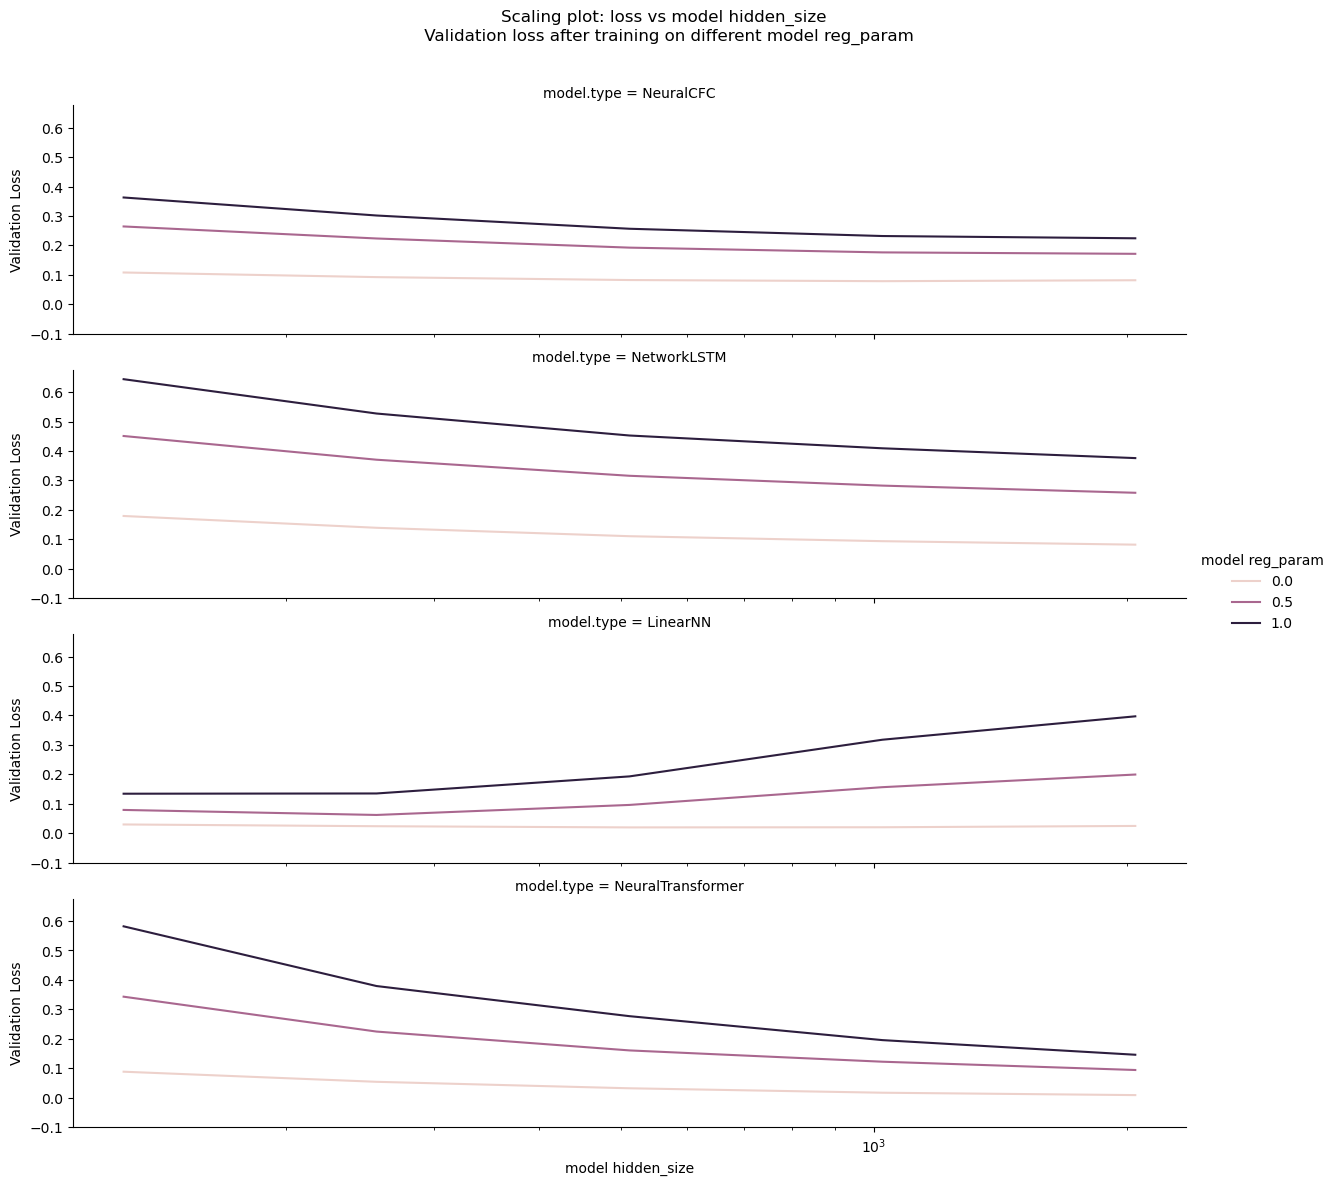

In [2]:
# Call the function with different hyperparameter combinations

df = plot_loss_vs_parameter(
    "../logs/hydra/experiment_1",
    "model.hidden_size",
    "model.reg_param",
    "model.type",
)

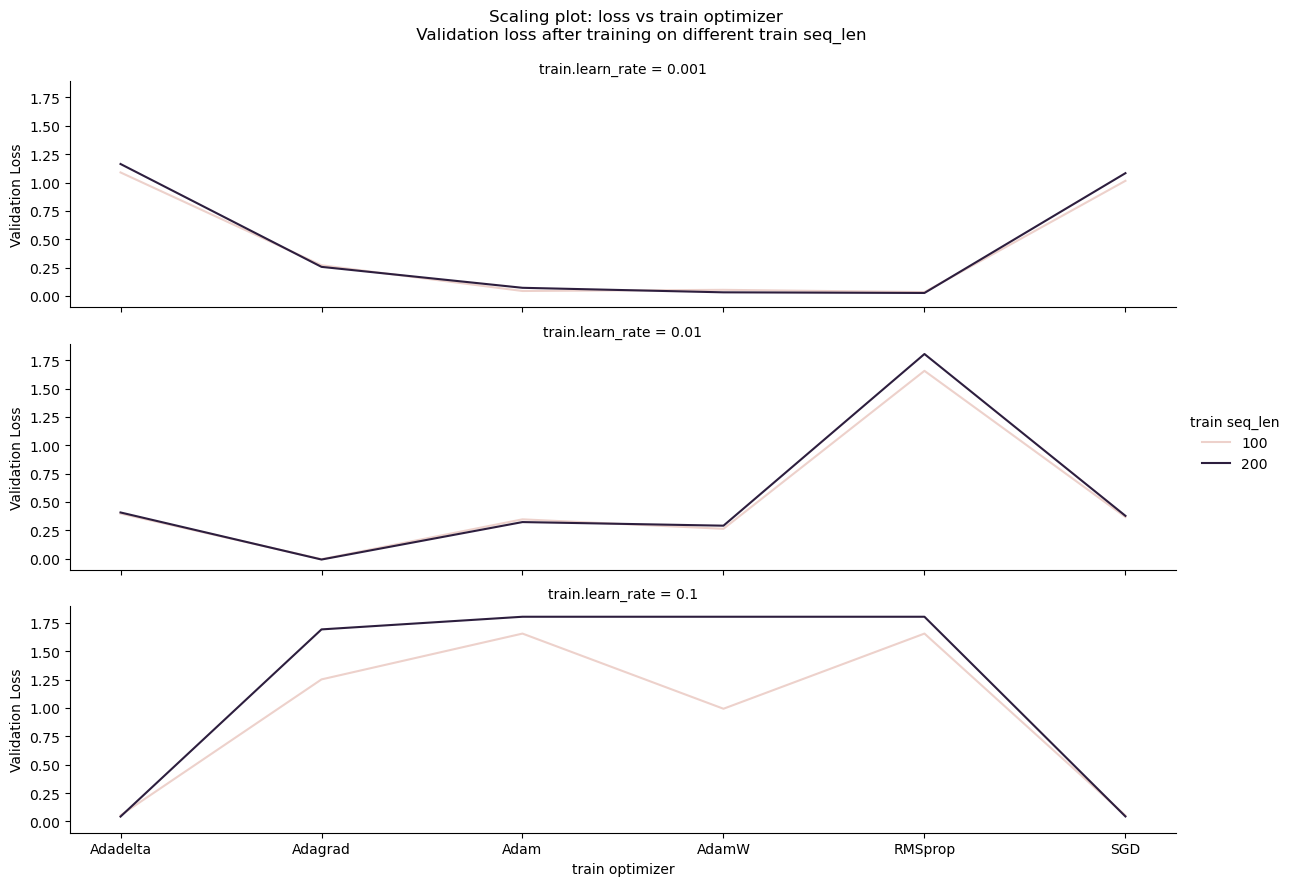

In [5]:
df = plot_loss_vs_parameter(
    "../logs/hydra/experiment_2",
    "train.optimizer",
    "train.seq_len",
    "train.learn_rate",
)

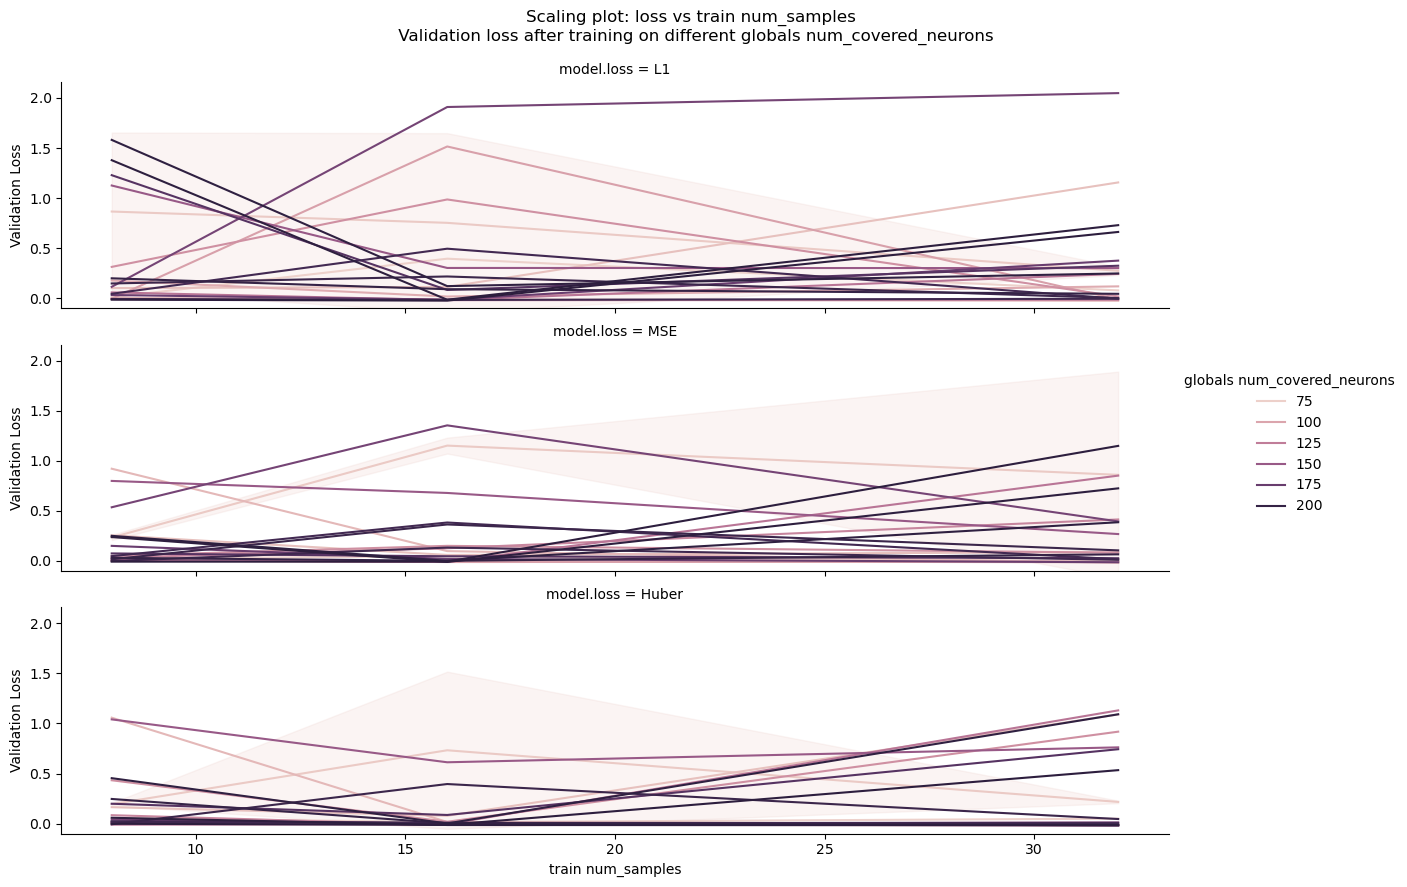

In [9]:
df = plot_loss_vs_parameter(
    "../logs/hydra/experiment_3",
    "train.num_samples",
    "globals.num_covered_neurons",
    "model.loss",
)